### PyTorch Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 50

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize each image to 32x32 to fit to Lenet5 original dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the base LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False, dropout_prob=0.5):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=[5, 5])
        self.avg_pool1 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=[5, 5])
        self.avg_pool2 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=[5, 5])
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        if use_batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(6)
            self.batch_norm2 = nn.BatchNorm2d(16)
            self.batch_norm3 = nn.BatchNorm2d(120)
        if use_dropout:
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.avg_pool2(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.batch_norm3(x)
        x = F.relu(x)

        x = torch.flatten(x, 1)
        if self.use_dropout:
            x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = F.softmax(self.fc2(x), dim=1)
        return x

# Train and evaluate the model
def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader):
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accs.append(correct / total)

        # Evaluate on test data
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accs.append(correct / total)

    return train_accs, test_accs

# Plot convergence graphs
def plot_convergence(train_acc, test_acc, title):
    # Find the epoch that has the highest test accuracy
    best_epoch = test_acc.index(max(test_acc))  # Index of the highest test accuracy
    best_train_acc = train_acc[best_epoch]  # Training accuracy at the best epoch
    best_test_acc = test_acc[best_epoch]    # Test accuracy at the best epoch

    # Plot the training and test accuracies
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    
    # Annotate the best epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Best Epoch: {best_epoch+1}")
    plt.annotate(f"Train Acc: {best_train_acc:.2f}\nTest Acc: {best_test_acc:.2f}",
                 xy=(best_epoch, best_test_acc),
                 xytext=(best_epoch + 2, best_test_acc - 0.1),  # Slight offset for better visibility
                 arrowprops=dict(arrowstyle="->", color='red'),
                 fontsize=10, color='red')

    # Add titles and labels
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Save the plot with padding
    plot_path = f'./results/{title}.png'
    plt.savefig(plot_path, bbox_inches='tight', pad_inches=0.1)  # Adding padding around the image
    plt.show()

    print(f"Plot saved to: {plot_path}")


### Experiments

In [ ]:
criterion = nn.CrossEntropyLoss()

# Without Regularization
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_acc, test_acc = train_and_evaluate(model, optimizer, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_without_reg.pth')

In [ ]:
# With Dropout
model_dropout = LeNet5(use_dropout=True).to(device)
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=learning_rate)
train_acc_dropout, test_acc_dropout = train_and_evaluate(model_dropout, optimizer_dropout, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_dropout.pth')

In [ ]:
# With Weight Decay (L2 Regularization)
model_l2 = LeNet5().to(device)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=0.0001)
train_acc_l2, test_acc_l2 = train_and_evaluate(model_l2, optimizer_l2, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_weight_decay.pth')

In [ ]:
# With Batch Normalization
model_bn = LeNet5(use_batch_norm=True).to(device)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=learning_rate)
train_acc_bn, test_acc_bn = train_and_evaluate(model_bn, optimizer_bn, criterion, train_loader, test_loader)
torch.save(model.state_dict(), 'LetNet5_batch_norm.pth')

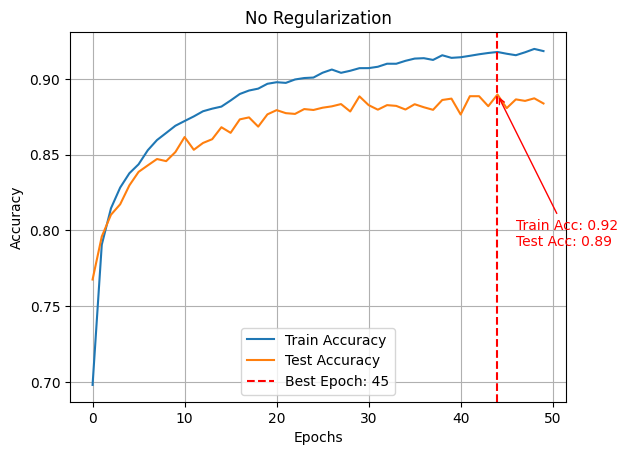

Plot saved to: ./results/No Regularization.png


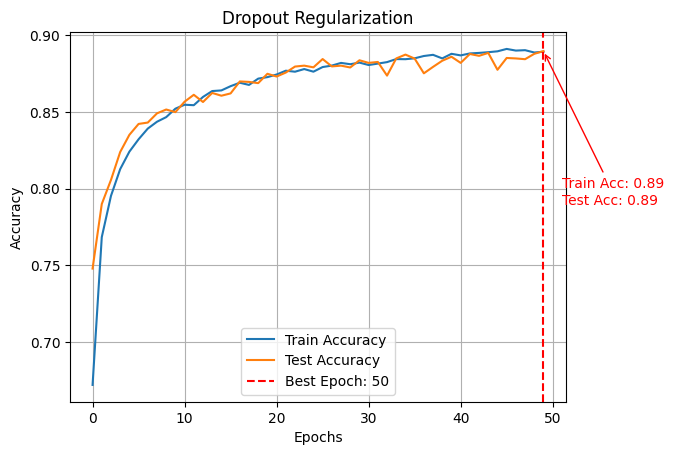

Plot saved to: ./results/Dropout Regularization.png


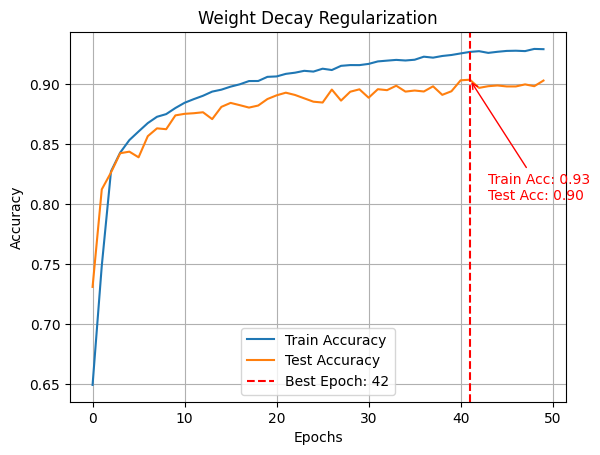

Plot saved to: ./results/Weight Decay Regularization.png


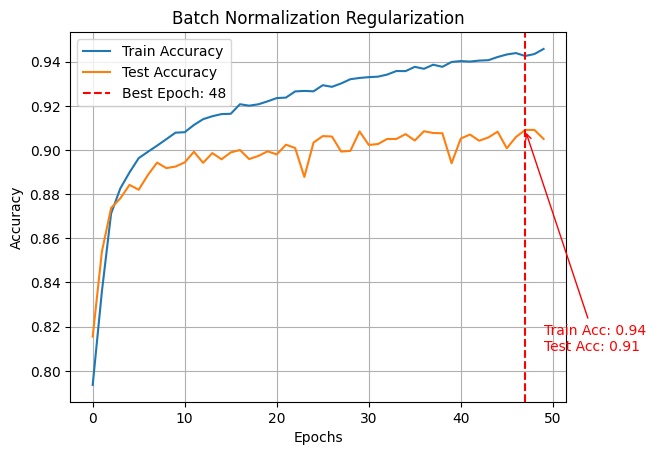

Plot saved to: ./results/Batch Normalization Regularization.png


In [34]:
# genearte all the plots
plot_convergence(train_acc, test_acc, "No Regularization")
plot_convergence(train_acc_dropout, test_acc_dropout, "Dropout Regularization")
plot_convergence(train_acc_l2, test_acc_l2, "Weight Decay Regularization")
plot_convergence(train_acc_bn, test_acc_bn, "Batch Normalization Regularization")

In [29]:
import pandas as pd

# take max accuracies 
results = {
    "Technique": [
        "No Regularization",
        "Dropout",
        "Weight Decay (L2)",
        "Batch Normalization"
    ],
    "Train Accuracy (%)": [
        max(train_acc) * 100,
        max(train_acc_dropout) * 100,
        max(train_acc_l2) * 100,
        max(train_acc_bn) * 100
    ],
    "Test Accuracy (%)": [
        max(test_acc) * 100,
        max(test_acc_dropout) * 100,
        max(test_acc_l2) * 100,
        max(test_acc_bn) * 100
    ],
}


# Create DataFrame
df_results = pd.DataFrame(results)

# Display DataFrame
display(df_results)

# Optionally save to a CSV file
df_results.to_csv("./results/lenet5_results.csv", index=False)

,Technique,Train Accuracy (%),Test Accuracy (%)
0,No Regularization,91.993333,88.98
1,Dropout,89.110000,88.97
2,Weight Decay (L2),92.923333,90.36
3,Batch Normalization,94.578333,90.91


### Update README

In [30]:
import pandas as pd

# Read the CSV file
csv_path = "./results/lenet5_results.csv"
data = pd.read_csv(csv_path)

# Generate the Markdown table manually
header = "| " + " | ".join(data.columns) + " |"
separator = "| " + " | ".join(["-" * len(col) for col in data.columns]) + " |"
rows = "\n".join(["| " + " | ".join(map(str, row)) + " |" for row in data.values])

table_md = f"{header}\n{separator}\n{rows}"

# Read the existing README file
readme_path = "./README.md"
with open(readme_path, "r") as file:
    readme_content = file.read()

# Append the table to the README
updated_readme = f"{readme_content}\n\n## LeNet5 Results\n\n{table_md}\n"

# Write the updated content back to the README
with open(readme_path, "w") as file:
    file.write(updated_readme)

print("README.md updated successfully with the table from lenet5_results.csv.")


README.md updated successfully with the table from lenet5_results.csv.
